### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Load data

In [3]:
df = pd.read_csv('/home/azureuser/project_gazebo/metric_logs/metrics_2024-06-04-15-04-56.csv')
df

,timestamp,namespace,position_x,position_y,position_z,orientation_x,orientation_y,orientation_z,orientation_w,linear_x,...,raw_detection_4_size_y,raw_detection_4_score,raw_detection_4_aspect_ratio,raw_detection_5_camera,raw_detection_5_bbox_x,raw_detection_5_bbox_y,raw_detection_5_size_x,raw_detection_5_size_y,raw_detection_5_score,raw_detection_5_aspect_ratio
0,1717513497,drone0,-1.000000,-0.577350,0.001697,9.276246e-17,1.260347e-16,1.819334e-17,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1717513497,drone1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1717513497,drone2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1717513497,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1717513498,drone0,-1.000000,-0.577350,0.001697,9.276246e-17,1.260347e-16,1.819334e-17,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,1717514984,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5952,1717514985,drone0,3.281810,0.720862,10.016625,-5.572224e-03,-5.268649e-03,6.279019e-05,0.999971,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5953,1717514985,drone1,5.015532,1.767760,10.010892,-5.154750e-03,3.816514e-03,-5.751538e-05,0.999979,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5954,1717514985,drone2,4.192459,2.641059,10.004459,3.421397e-02,-1.191142e-02,-8.517509e-05,0.999344,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot x-y positions

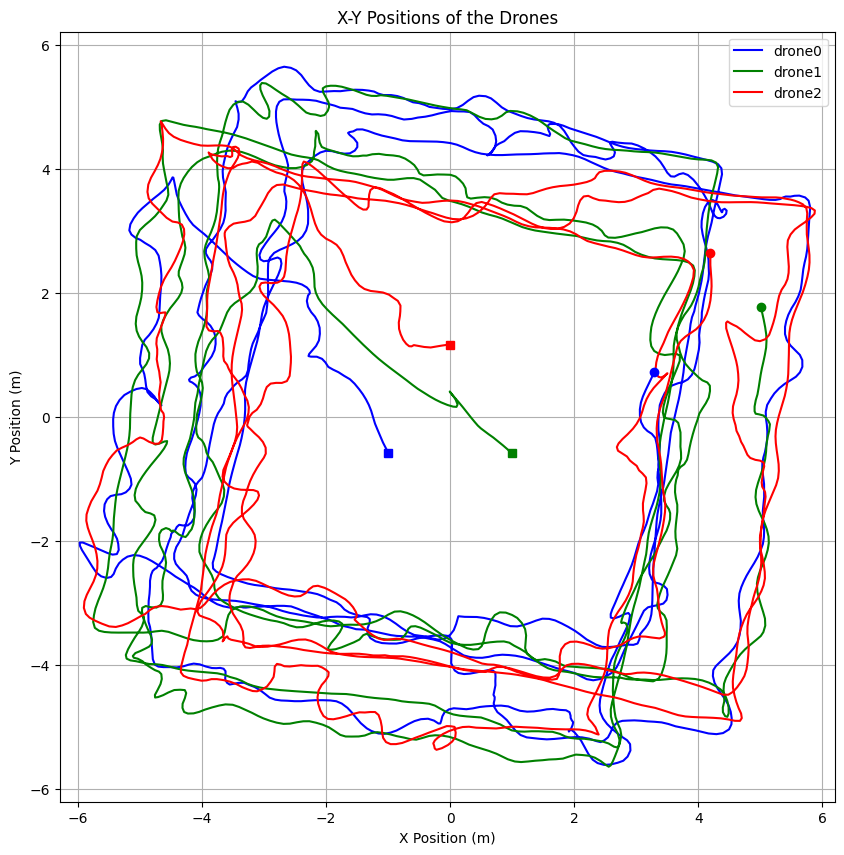

In [4]:


# plot the data

# Filter data for drones
drones_data = df[df['namespace'].str.contains('drone')]

# Extract x and y positions
drone_positions = drones_data[['namespace', 'position_x', 'position_y']]

# Plot the positions of the drones
plt.figure(figsize=(10, 10))

drone_colours = ['b', 'g', 'r']

starting_positions = drone_positions.groupby('namespace').first().dropna()
ending_positions = drone_positions.groupby('namespace').last().dropna()
 

for i, drone in enumerate(drone_positions['namespace'].unique()):
    drone_data = drone_positions[drone_positions['namespace'] == drone]
    plt.plot(drone_data['position_x'], drone_data['position_y'], label=drone, color=drone_colours[i])

# mark the starting position of the drones, which is the first position in the dataset for each drone which isn't NaN

for i, drone in enumerate(starting_positions.index):
    plt.plot(starting_positions.loc[drone, 'position_x'], starting_positions.loc[drone, 'position_y'], 's', color= drone_colours[i])
    # plot the ending position of the drones, which is the last position in the dataset for each drone which isn't NaN


for i, drone in enumerate(ending_positions.index):
    plt.plot(ending_positions.loc[drone, 'position_x'], ending_positions.loc[drone, 'position_y'], 'o',color= drone_colours[i])


# make axis equal
plt.axis('equal')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
# set axis as equal
plt.axis('equal')

plt.title('X-Y Positions of the Drones')
# set legend as only the drone names


plt.legend()
plt.grid(True)
plt.show()


In [5]:
# convert timestamp to seconds and add as new column
# Ensure 'timestamp' column is in datetime format
min_timestamp = df['timestamp'].min()
df['time_seconds'] = (df['timestamp'] - min_timestamp)
# separate the data for each average_distance topic
df_mean = df[['time_seconds', 'average_distance']].dropna()
df_min = df[['time_seconds', 'min_distance']].dropna()
df_max = df[['time_seconds', 'max_distance']].dropna()
df_std = df[['time_seconds', 'std_distance']].dropna()


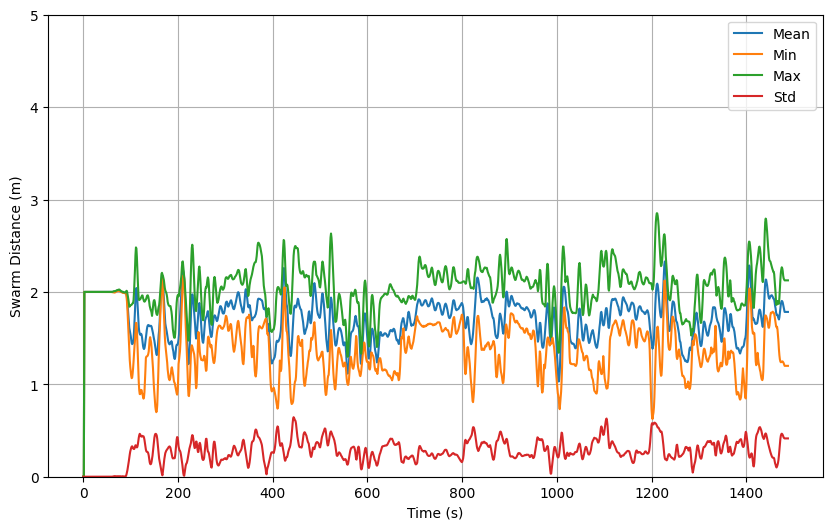

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df_mean['time_seconds'], df_mean['average_distance'], label='Mean')
plt.plot(df_min['time_seconds'], df_min['min_distance'], label='Min')
plt.plot(df_max['time_seconds'], df_max['max_distance'], label='Max')
plt.plot(df_std['time_seconds'], df_std['std_distance'], label='Std')
plt.xlabel('Time (s)')
plt.ylabel('Swarm Distance (m)')
# set y axis limits to 0 and 5
plt.ylim(0, 5)
# show grid
plt.grid()
plt.legend()
plt.show()

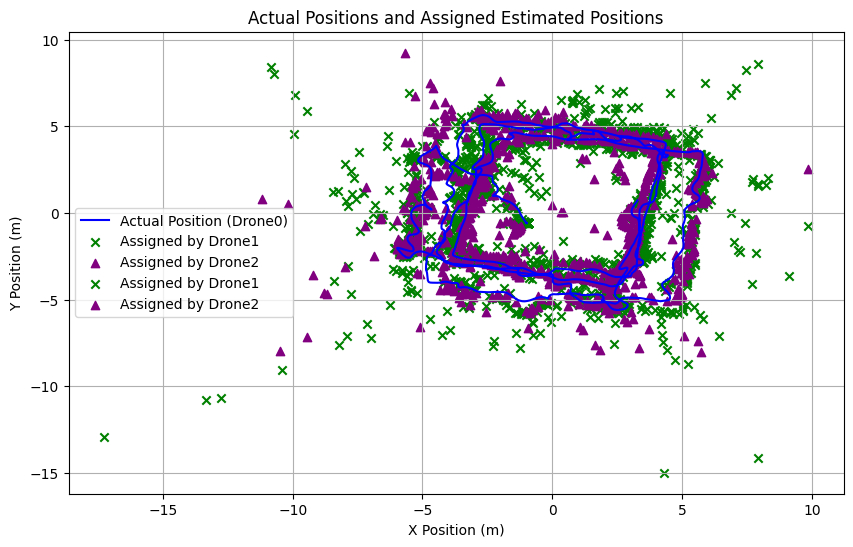

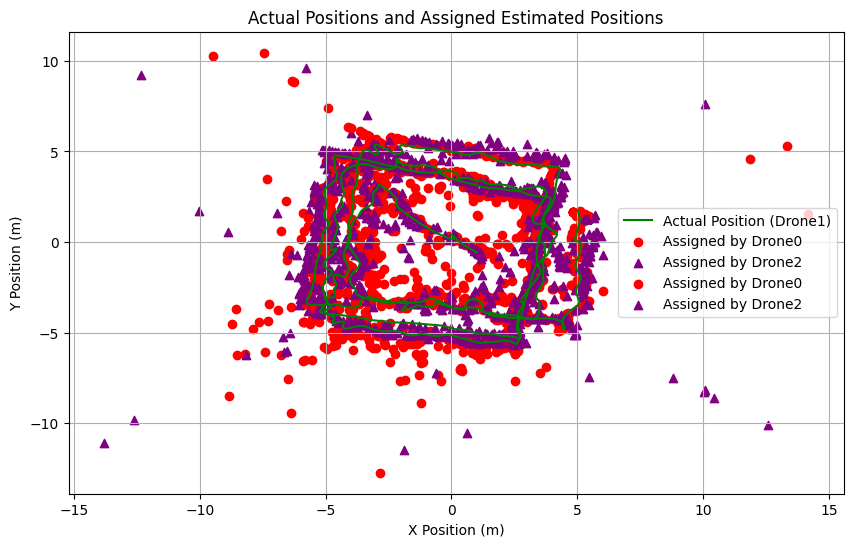

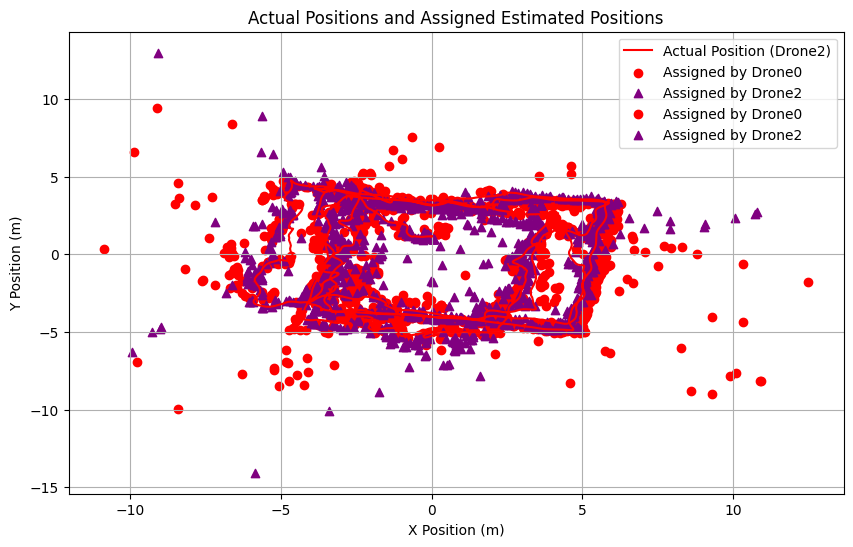

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

data = df

# Define a function to calculate the Euclidean distance
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Remove rows where all 'estimated_position_*' columns are NaN
estimated_position_columns = [col for col in data.columns if 'estimated_position' in col]
filtered_data = data.dropna(subset=estimated_position_columns, how='all')

# Filter out the timestamps where we don't have entries for all 3 drones
timestamp_counts = filtered_data.groupby(['timestamp', 'namespace']).size().unstack(fill_value=0)
valid_timestamps = timestamp_counts[timestamp_counts.sum(axis=1) == 3].index
filtered_data = filtered_data[filtered_data['timestamp'].isin(valid_timestamps)]

# Select only the required columns
columns_to_keep = ['timestamp', 'time_seconds', 'namespace', 'position_x', 'position_y'] + estimated_position_columns
reduced_data = filtered_data[columns_to_keep]

# Prepare the dataframe to store the results
columns = ['timestamp', 'time_seconds', 'namespace', 'assigned_estimated_position_1_x', 'assigned_estimated_position_1_y',
           'assigned_estimated_position_2_x', 'assigned_estimated_position_2_y']
results = []

# Iterate over each unique timestamp
for timestamp in reduced_data['timestamp'].unique():
    # Filter data for the current timestamp
    timestamp_data = reduced_data[reduced_data['timestamp'] == timestamp]
    
    # Collect the actual positions and estimated positions
    actual_positions = {}
    estimated_positions = defaultdict(list)
    
    for index, row in timestamp_data.iterrows():
        namespace = row['namespace']
        actual_positions[namespace] = (row['position_x'], row['position_y'])
        
        for col in estimated_position_columns:
            if 'x' in col:
                x_col = col
                y_col = col.replace('_x', '_y')
                est_x = row[x_col]
                est_y = row[y_col]
                if not np.isnan(est_x) and not np.isnan(est_y):
                    estimated_positions[namespace].append((est_x, est_y))
    
    # Prepare to track which positions have been assigned
    assigned_positions = {ns: [] for ns in actual_positions}
    
    # Assign each estimated position to the closest drone
    for namespace, est_list in estimated_positions.items():
        for est in est_list:
            closest_dist = float('inf')
            closest_namespace = None
            
            for ns, pos in actual_positions.items():
                if len(assigned_positions[ns]) < 2:  # Ensure only two assignments per drone
                    dist = euclidean_distance(est[0], est[1], pos[0], pos[1])
                    if dist < closest_dist:
                        closest_dist = dist
                        closest_namespace = ns
            
            if closest_namespace is not None:
                assigned_positions[closest_namespace].append((est, namespace))
    
    # Compile the results for each drone
    for namespace in actual_positions:
        assigned_estimates = []
        assigned_drones = []
        for est, drone in assigned_positions[namespace]:
            assigned_estimates.extend(est)
            assigned_drones.append(drone)
        
        # ensure there is the correct number of assigned estimates
        if len(assigned_estimates) < 4:
            assigned_estimates.extend([np.nan, np.nan])

        if len(assigned_drones) < 2:
            assigned_drones.extend([np.nan])

     
        time_seconds = timestamp_data['time_seconds'].iloc[0]
        
        results.append([timestamp, time_seconds, namespace] + assigned_estimates + assigned_drones)

columns += ['assigned_position_1_drone', 'assigned_position_2_drone']

# Create a DataFrame from the results
assigned_positions_df = pd.DataFrame(results, columns=columns)

# Merge the original estimated positions back with the assigned positions and original positions for comparison
final_columns_to_merge = ['timestamp', 'time_seconds', 'namespace', 'position_x', 'position_y'] + estimated_position_columns
final_merged_df = pd.merge(assigned_positions_df, reduced_data[final_columns_to_merge], on=['timestamp', 'namespace'])

# Filter the data for drone1
drone0_data = final_merged_df[final_merged_df['namespace'] == 'drone0']
drone1_data = final_merged_df[final_merged_df['namespace'] == 'drone1']
drone2_data = final_merged_df[final_merged_df['namespace'] == 'drone2']

# Prepare the plot
plt.figure(figsize=(10, 6))

# Plot the actual positions for each drone
plt.plot(drone0_data['position_x'], drone0_data['position_y'], label='Actual Position (Drone0)', color='blue', linestyle='-')
# plt.plot(drone1_data['position_x'], drone1_data['position_y'], label='Actual Position (Drone2)', color='orange', linestyle='-')
# plt.plot(drone2_data['position_x'], drone2_data['position_y'], label='Actual Position (Drone3)', color='green', linestyle='-')

# Plot the assigned estimated positions, coloring them differently by the assigned drone
for drone_data in [drone0_data]:
    for i in range(1, 3):
        mask = drone_data[f'assigned_position_{i}_drone'] == 'drone1'
        plt.scatter(drone_data.loc[mask, f'assigned_estimated_position_{i}_x'], drone_data.loc[mask, f'assigned_estimated_position_{i}_y'],
                    label='Assigned by Drone1', color='green', marker='x')

        mask = drone_data[f'assigned_position_{i}_drone'] == 'drone2'
        plt.scatter(drone_data.loc[mask, f'assigned_estimated_position_{i}_x'], drone_data.loc[mask, f'assigned_estimated_position_{i}_y'],
                    label='Assigned by Drone2', color='purple', marker='^')

# Add labels and legend
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Actual Positions and Assigned Estimated Positions')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(drone1_data['position_x'], drone1_data['position_y'], label='Actual Position (Drone1)', color='green', linestyle='-')
# plt.plot(drone1_data['position_x'], drone1_data['position_y'], label='Actual Position (Drone2)', color='orange', linestyle='-')
# plt.plot(drone2_data['position_x'], drone2_data['position_y'], label='Actual Position (Drone3)', color='green', linestyle='-')

# Plot the assigned estimated positions, coloring them differently by the assigned drone
for drone_data in [drone1_data]:
    for i in range(1, 3):
        mask = drone_data[f'assigned_position_{i}_drone'] == 'drone0'
        plt.scatter(drone_data.loc[mask, f'assigned_estimated_position_{i}_x'], drone_data.loc[mask, f'assigned_estimated_position_{i}_y'],
                    label='Assigned by Drone0', color='red', marker='o')

        mask = drone_data[f'assigned_position_{i}_drone'] == 'drone2'
        plt.scatter(drone_data.loc[mask, f'assigned_estimated_position_{i}_x'], drone_data.loc[mask, f'assigned_estimated_position_{i}_y'],
                    label='Assigned by Drone2', color='purple', marker='^')


plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Actual Positions and Assigned Estimated Positions')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 6))

plt.plot(drone2_data['position_x'], drone2_data['position_y'], label='Actual Position (Drone2)', color='red', linestyle='-')
# plt.plot(drone1_data['position_x'], drone1_data['position_y'], label='Actual Position (Drone2)', color='orange', linestyle='-')
# plt.plot(drone2_data['position_x'], drone2_data['position_y'], label='Actual Position (Drone3)', color='green', linestyle='-')

# Plot the assigned estimated positions, coloring them differently by the assigned drone
for drone_data in [drone2_data]:
    for i in range(1, 3):
        mask = drone_data[f'assigned_position_{i}_drone'] == 'drone0'
        plt.scatter(drone_data.loc[mask, f'assigned_estimated_position_{i}_x'], drone_data.loc[mask, f'assigned_estimated_position_{i}_y'],
                    label='Assigned by Drone0', color='red', marker='o')

        mask = drone_data[f'assigned_position_{i}_drone'] == 'drone1'
        plt.scatter(drone_data.loc[mask, f'assigned_estimated_position_{i}_x'], drone_data.loc[mask, f'assigned_estimated_position_{i}_y'],
                    label='Assigned by Drone2', color='purple', marker='^')


plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Actual Positions and Assigned Estimated Positions')
plt.legend()
plt.grid(True)
plt.show()


# print(drone1_data)

# Prepare the plot
# plt.figure(figsize=(10, 6))

# Plot the actual positions
# plt.plot(drone1_data['position_x'], drone1_data['position_y'], label='Actual Position (Drone1)', color='blue', linestyle='-')

# Plot the assigned estimated positions, colouring them differently by the assigned drone



# plt.scatter(drone1_data['assigned_estimated_position_1_x'], drone1_data['assigned_estimated_position_1_y'], 
#             label='Assigned Estimated Position 1', color='red', marker='o')
# plt.scatter(drone1_data['assigned_estimated_position_2_x'], drone1_data['assigned_estimated_position_2_y'], 
#             label='Assigned Estimated Position 2', color='green', marker='x')

# Add labels and legend




/tmp/ipykernel_25239/2480440663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drone0_data['error_1'] = drone0_data.apply(lambda row: euclidean_distance(row['position_x'], row['position_y'], row['assigned_estimated_position_1_x'], row['assigned_estimated_position_1_y']), axis=1)
/tmp/ipykernel_25239/2480440663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drone0_data['error_2'] = drone0_data.apply(lambda row: euclidean_distance(row['position_x'], row['position_y'], row['assigned_estimated_positio

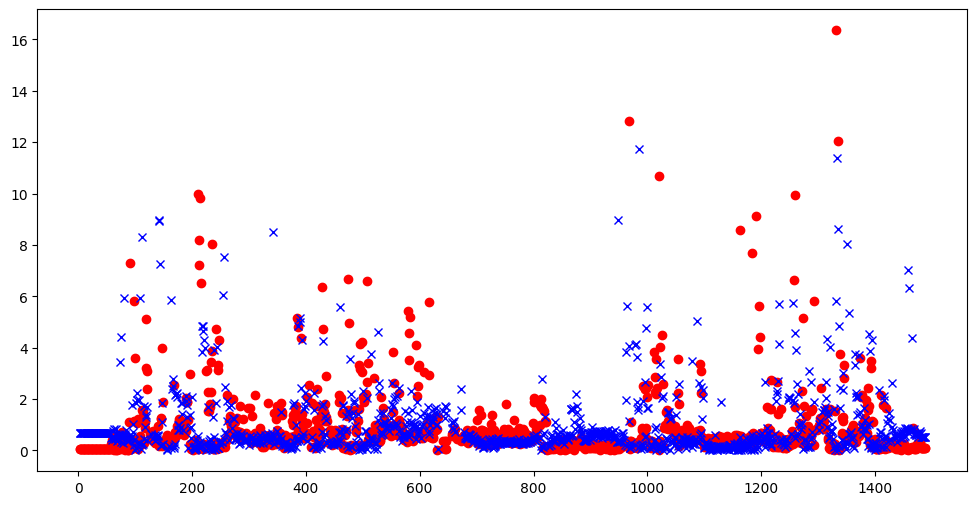

In [12]:
drone0_data['error_1'] = drone0_data.apply(lambda row: euclidean_distance(row['position_x'], row['position_y'], row['assigned_estimated_position_1_x'], row['assigned_estimated_position_1_y']), axis=1)
drone0_data['error_2'] = drone0_data.apply(lambda row: euclidean_distance(row['position_x'], row['position_y'], row['assigned_estimated_position_2_x'], row['assigned_estimated_position_2_y']), axis=1)

# Plot the error representation for drone0 for each timestamp
plt.figure(figsize=(12, 6))

plt.plot(drone0_data['time_seconds_x'], drone0_data['error_1'], label='Error 1', color='red', linestyle='', marker='o')
plt.plot(drone0_data['time_seconds_x'], drone0_data['error_2'], label='Error 2', color='blue', linestyle='', marker='x')


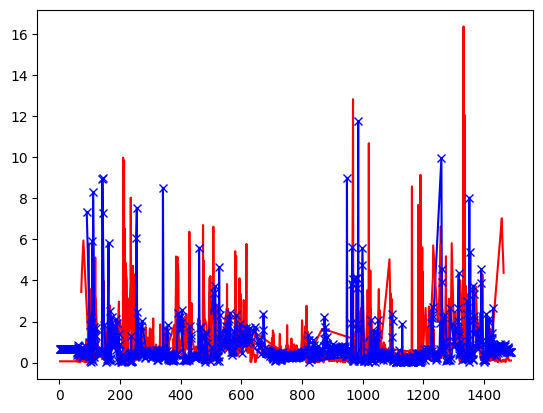

In [20]:

for drone_data in [drone0_data]:
    for i in range(1, 3):
        mask = drone_data[f'assigned_position_{i}_drone'] == 'drone1'
        plt.scatter(drone_data.loc[mask, 'time_seconds_x'], drone_data.loc[mask, f'error_{i}'],
                    label='Assigned by Drone0', color='red', marker='o')
        
        mask = drone_data[f'assigned_position_{i}_drone'] == 'drone2'
        plt.plot(drone_data.loc[mask, 'time_seconds_x'], drone_data.loc[mask, f'error_{i}'],
                    label='Assigned by Drone1', color='blue', marker='x')


        # mask = drone_data[f'assigned_position_{i}_drone'] == 'drone1'
        # plt.scatter(drone_data.loc[mask, f'assigned_estimated_position_{i}_x'], drone_data.loc[mask, f'assigned_estimated_position_{i}_y'],
        #             label='Assigned by Drone2', color='purple', marker='^')